In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from scipy import stats
import missingno as msno
from datetime import datetime

from collections import Counter

from sklearn.ensemble import RandomForestRegressor, \
                             AdaBoostRegressor, \
                            GradientBoostingRegressor, \
                            ExtraTreesRegressor \
                           

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression,Ridge,Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn import metrics


sns.set(style='white', context='notebook', palette='deep')


In [10]:
# load the data
dailyData = pd.read_csv('../input/train.csv', parse_dates=[0])
test = pd.read_csv('../input/test.csv')


In [11]:
dailyData.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
dailyData.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [8]:
dailyData.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [40]:
datetime.date(dailyData['datetime'].iloc[1]).weekday()

5

In [42]:
dailyData['date'] = dailyData['datetime'].apply(lambda x: x.day)
dailyData['hour'] = dailyData['datetime'].apply(lambda x: x.hour)
dailyData['weekday'] = dailyData['datetime'].apply(lambda dateString: calendar.day_name[datetime.date(dateString).weekday()])
dailyData['month'] = dailyData.datetime.apply(lambda dateString: calendar.month_name[datetime.date(dateString).month])
dailyData['season'] = dailyData.season.map({1:'Srping', 2:'Summer', 3:'fall', 4:'winter'})
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [43]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,1,0,Saturday,January
1,2011-01-01 01:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,1,1,Saturday,January
2,2011-01-01 02:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,1,2,Saturday,January
3,2011-01-01 03:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,3,10,13,1,3,Saturday,January
4,2011-01-01 04:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,0,1,1,1,4,Saturday,January


# geting category type for some columns


In [45]:
category_variable_list = ['hour', 'weekday', 'month', 'season', 'weather', 'holiday', 'workingday']
for var in category_variable_list:
    dailyData[var] = dailyData[var].astype('category')

dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,1,0,Saturday,January
1,2011-01-01 01:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,1,1,Saturday,January
2,2011-01-01 02:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,1,2,Saturday,January
3,2011-01-01 03:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,3,10,13,1,3,Saturday,January
4,2011-01-01 04:00:00,Srping,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,0,1,1,1,4,Saturday,January


In [46]:
dailyData = dailyData.drop(['datetime'], axis=1)

# checking mising value using msno (missingno)

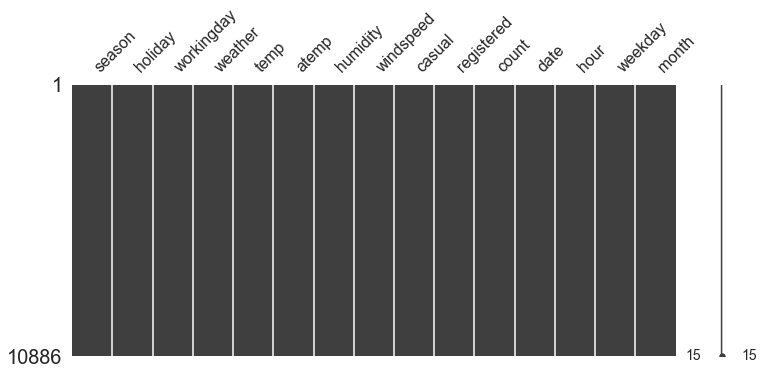

In [47]:
msno.matrix(dailyData,figsize=(12, 5))

# Checking outliers using box plot


At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).But in addition to that, following inferences can also been made from the simple boxplots given below.

- Spring season has got relatively lower count.The dip in median value in boxplot gives evidence for it.
- The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.
- Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count Across Working Day')]

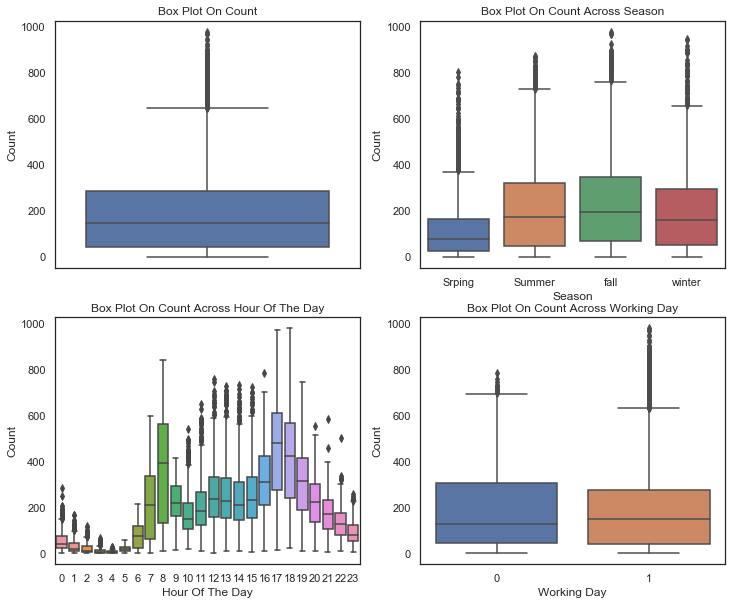

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=dailyData, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=dailyData, y='count', x='season', orient='v', ax=axes[0][1])
sns.boxplot(data=dailyData, y='count', x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=dailyData, y='count', x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [51]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData['count']-dailyData['count'].mean())<=(3*dailyData['count'].std())]
print(dailyData.shape)
print(dailyDataWithoutOutliers.shape)                                  

(10886, 15)
(10739, 15)


# Correlation Analysis
One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

- temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".
- windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
- "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
- "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

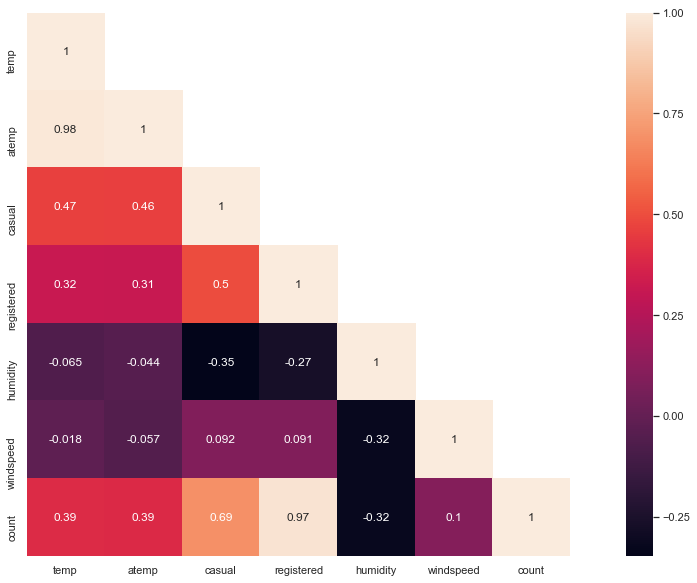

In [58]:
col_names = ['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']
corrMatt = dailyData[col_names].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrMatt, vmax=1, mask=mask, square=True, annot=True)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


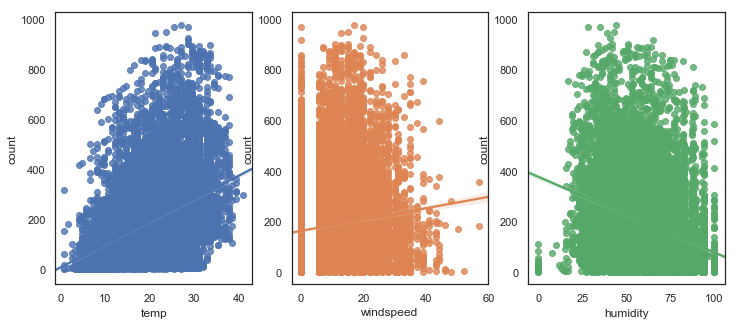

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
sns.regplot(x='temp', y='count', data=dailyData, ax=ax1)
sns.regplot(x='windspeed', y='count', data=dailyData, ax=ax2)
sns.regplot(x='humidity', y='count', data=dailyData, ax=ax3)


# Visualizing Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

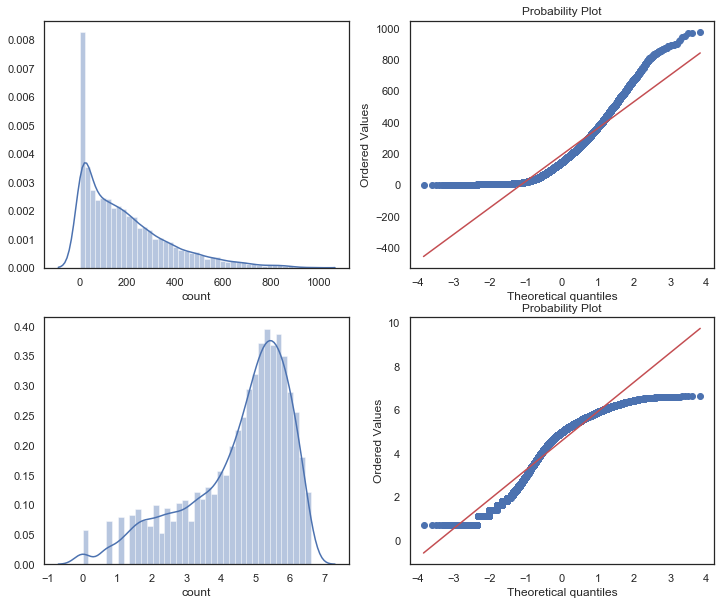

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.distplot(dailyData['count'], ax=axes[0][0])
stats.probplot(dailyData['count'], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(dailyDataWithoutOutliers['count']), ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers['count']), dist='norm', fit=True, plot=axes[1][1])

# Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)
- It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
- On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
- Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
- The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User Type'),
 None]

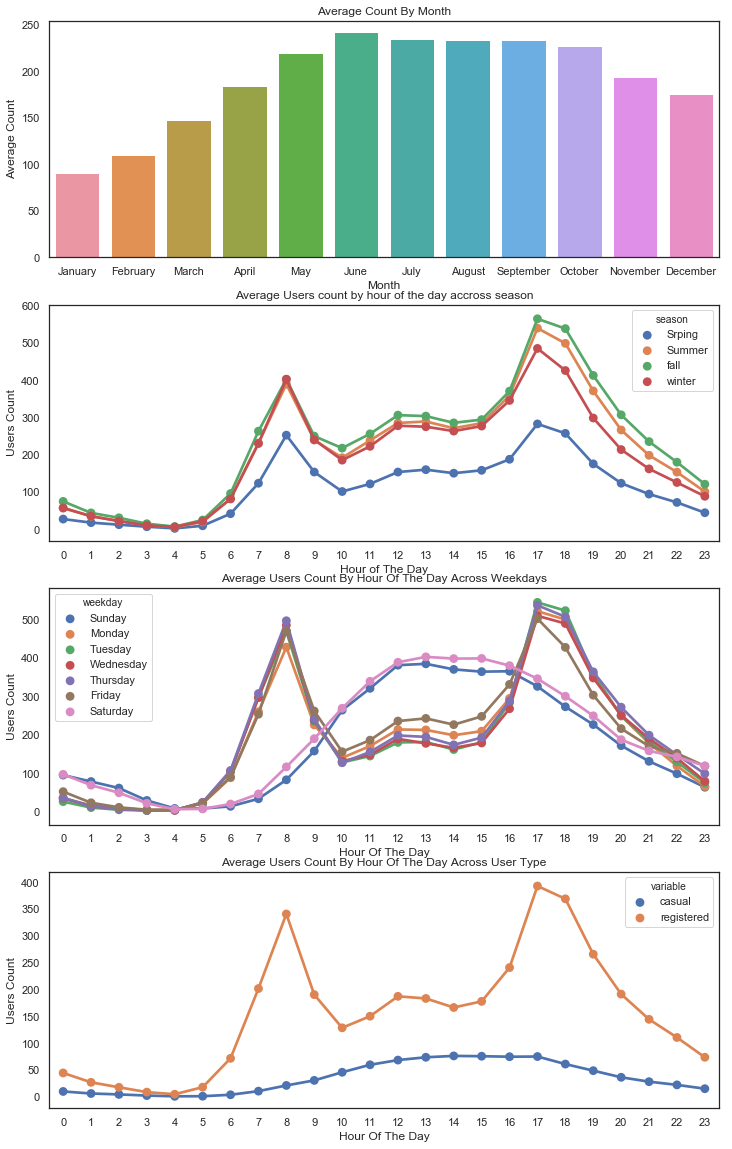

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 20))

sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby('month')['count'].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by='count', ascending=False)
sns.barplot(data=monthSorted, x='month', y='count', ax=ax1, order=sortOrder)
ax1.set(xlabel='Month', ylabel='Average Count', title='Average Count By Month')

hourAggregated = pd.DataFrame(dailyData.groupby(['hour', 'season'], sort=True)['count'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['count'], hue=hourAggregated['season'], data=hourAggregated, join=True, ax=ax2)
ax2.set(xlabel='Hour of The Day', ylabel='Users Count', title='Average Users count by hour of the day accross season', label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

In [2]:
data_train = pd.read_csv("../input/train.csv", parse_dates=[0])
data_test = pd.read_csv("../input/test.csv", parse_dates=[0])

In [3]:
data_train_without_outliers = data_train[np.abs(data_train['count']-data_train['count'].mean())<=(3*data_train['count'].std())]
train_size = data_train_without_outliers.shape[0]
print(train_size)

10739


In [4]:
data = pd.concat([data_train_without_outliers, data_test], axis=0, sort=False).reset_index(drop=True)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [6]:
data['date'] = pd.DatetimeIndex(data['datetime']).day
data['hour'] = pd.DatetimeIndex(data['datetime']).hour
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['weekday'] = pd.DatetimeIndex(data['datetime']).weekday
data['month'] = pd.DatetimeIndex(data['datetime']).month
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,1,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,1,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,1,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,1,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,1,4,2011,5,1


In [17]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [14]:
col_names = data.columns
for col in col_names:
    print(f'Total unique values for {col} is: {len(data[col].unique())}')

Total unique values for datetime is: 17232
Total unique values for season is: 4
Total unique values for holiday is: 2
Total unique values for workingday is: 2
Total unique values for weather is: 4
Total unique values for temp is: 50
Total unique values for atemp is: 65
Total unique values for humidity is: 89
Total unique values for windspeed is: 30
Total unique values for casual is: 307
Total unique values for registered is: 653
Total unique values for count is: 715
Total unique values for date is: 31
Total unique values for hour is: 24
Total unique values for year is: 2
Total unique values for weekday is: 7
Total unique values for month is: 12


In [15]:
data['season'] = data['season'].astype('category')

In [18]:
# convert each categorical to dummies
for var in categoricalFeatureNames:
    data[var] = data[var].astype('category')
    
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,1,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,1,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,1,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,1,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,1,4,2011,5,1


In [21]:
data.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
date                   int64
hour                category
year                category
weekday             category
month               category
dtype: object

In [34]:
train = data[:train_size]
test = data[train_size:]
X_train = train.drop(labels=['datetime', 'casual', 'registered', 'count'], axis=1)
Y_train = train['count']
test_date_time = test['datetime']
X_test = test.drop(labels=['datetime', 'casual', 'registered', 'count'], axis=1)


In [31]:
X_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,year,weekday,month
10739,1,0,1,1,10.66,11.365,56,26.0027,20,0,2011,3,1
10740,1,0,1,1,10.66,13.635,56,0.0000,20,1,2011,3,1
10741,1,0,1,1,10.66,13.635,56,0.0000,20,2,2011,3,1
10742,1,0,1,1,10.66,12.880,56,11.0014,20,3,2011,3,1
10743,1,0,1,1,10.66,12.880,56,11.0014,20,4,2011,3,1
10744,1,0,1,1,9.84,11.365,60,15.0013,20,5,2011,3,1
10745,1,0,1,1,9.02,10.605,60,15.0013,20,6,2011,3,1
10746,1,0,1,1,9.02,10.605,55,15.0013,20,7,2011,3,1
10747,1,0,1,1,9.02,10.605,55,19.0012,20,8,2011,3,1
10748,1,0,1,2,9.84,11.365,52,15.0013,20,9,2011,3,1


# Fitting and predicting model

In [32]:
# Cross validate model with kfold stratified corss val
kfold = StratifiedKFold(n_splits=10)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot b

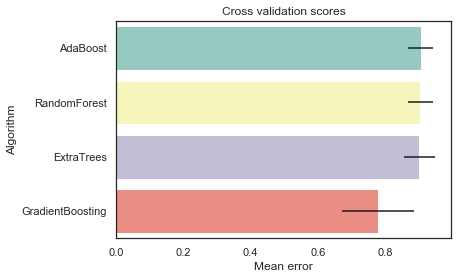

In [40]:
# modeling step Test diffrents algorithms
random_state = 2
Regressors = []
# classifiers.append(SVM(random_state=random_state))
# Regressors.append(DecisionTreeRegressor(random_state=random_state))
Regressors.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state), \
                                      random_state=random_state, learning_rate=0.1))
Regressors.append(RandomForestRegressor(random_state=random_state))
Regressors.append(ExtraTreesRegressor(random_state=random_state))
Regressors.append(GradientBoostingRegressor(random_state=random_state))


cv_results = []
for regressor in Regressors:
    cv_results.append(cross_val_score(regressor, X_train, y=Y_train, scoring='r2', cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting"]})
g= sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean error')
g = g.set_title('Cross validation scores')

In [41]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.905057,0.038166,AdaBoost
1,0.904855,0.036026,RandomForest
2,0.901526,0.046384,ExtraTrees
3,0.777713,0.106781,GradientBoosting


In [44]:
final_model = AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state), \
                                      random_state=random_state, learning_rate=0.1)
final_model.fit(X_train, Y_train)
y_test_pred = final_model.predict(X_test)
y_test_pred = [int(x) for x in y_test_pred]

In [46]:
submission = pd.DataFrame({
        "datetime": test_date_time,
        "count": y_test_pred
    })

submission.to_csv('../output/submission_ABR.csv', index=False)

In [43]:
y_test_pred

array([ 15.,   6.,   3., ..., 168., 106.,  64.])